In [37]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

DPI = 600
GRANULARITY = 200000

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

containingJoinSplit = blocks.loc[(blocks['numberJoinSplit'] != 0)]

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])
blocks["SIZE"] = blocks["SIZE"] / 1024 # Convert to KB

Blocks 00000000026713f4ef22ffc0096547fe88ccfe3987605e4a73c0abc617f1e926 till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


<Figure size 432x288 with 0 Axes>

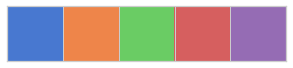

In [38]:
# Prepare plots
color = "muted"
sns.set(style="whitegrid", palette=color, color_codes=True)
sns.despine(left=True)
#plt.rcParams['figure.figsize'] = [16/2.54, 12/2.54]
color = sns.color_palette(color, 5)
sns.palplot(sns.color_palette(color, 5))
color_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]
color_gv = color[4]

In [39]:
blocks.loc[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Blocks containing ...'] = 'Only transparent TX' 
blocks.loc[~blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Blocks containing ...'] = '$> 1$ shielded TX'  
blocks.loc[blocks['BLOCK'].isin(containingJoinSplit['BLOCK']), 'Blocks containing ...'] = '$> 1$ JoinSplit TX'

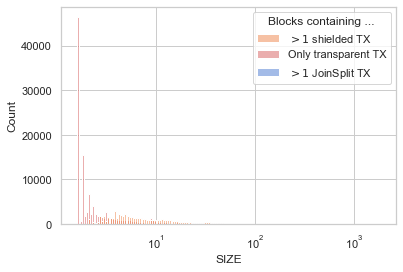

In [40]:
grid = sns.histplot(x="SIZE", data=blocks, hue='Blocks containing ...', log_scale=True, palette=[color_kv, color_r2, color_primary])

In [41]:
# Include block height
blocks_h = blocks.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
blocks_h = blocks_h.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
blocks_h = blocks_h.sort_values(by=['height'])
blocks_h['height'] = blocks_h['height'] / 1000

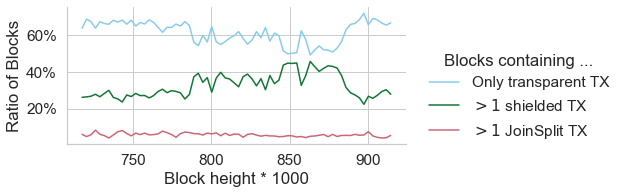

In [106]:
colors = ["#88CCEE", "#117733", "#CC6677", "#882255", "#AA4499"]
sns.set(style="whitegrid", color_codes=True, font_scale=1.4)

sns.set_palette(sns.color_palette(colors))

def move_legend(ax, new_loc, _ncol, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, ncol=_ncol, loc=new_loc, bbox_to_anchor=(0.5, -0.4), title=title, **kws)

from matplotlib.ticker import PercentFormatter 
BINS = 70
grid = sns.displot(bins=BINS, kind="hist", x="height", height=3, aspect=2, data=blocks_h, hue='Blocks containing ...', element="poly", fill=False, multiple='layer',weights=np.ones(len(blocks_h)) / (len(blocks_h) / BINS))
grid.set(xlabel='Block height * 1000', ylabel='Ratio of Blocks')
for ax in grid.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
grid.savefig("top_old.pdf", bbox_inches='tight', dpi=DPI)

In [45]:
blocks_h['SUM'] = blocks_h['numberVin_x'] + blocks_h['numberJoinSplit_x'] + blocks_h['numbervShieldedSpend_x'] + blocks_h['numbervShieldedOutput_x']
blocks_h['Transparent'] = blocks_h['numberVin_x']
blocks_h['Shielded'] = blocks_h['numbervShieldedSpend_x'] + blocks_h['numbervShieldedOutput_x']

blocks_h['Inputs'] = blocks_h['Transparent'] / blocks_h['SUM']
blocks_h['Spends & Outputs'] = blocks_h['Shielded'] / blocks_h['SUM']
blocks_h['JoinSplits'] = blocks_h['numberJoinSplit_x'] / blocks_h['SUM']

bock_per = pd.melt(blocks_h, id_vars=['BLOCK', 'height'], value_vars=['Inputs', 'Spends & Outputs', 'JoinSplits'], var_name='Transfer', value_name='%')

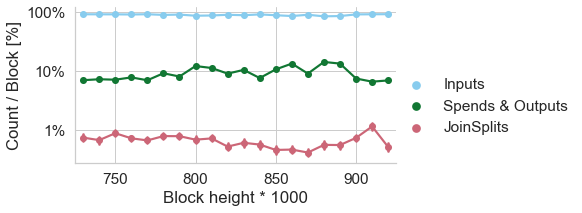

In [114]:
colors = ["#88CCEE", "#117733", "#CC6677", "#882255", "#AA4499"]
sns.set(style="whitegrid", color_codes=True, font_scale=1.4)
sns.set_palette(sns.color_palette(colors))

Q = 20
d1_bins = bock_per.copy(deep=True)
d1_bins['H_BINS'], edges = pd.qcut(d1_bins['height'], Q, retbins=True)
from matplotlib.ticker import FormatStrFormatter 
from numpy import mean
g = sns.catplot(x="H_BINS", 
                y="%",
                height=3,
                aspect=2,
                kind="point",
                estimator=mean,
                hue="Transfer",
                legend=False,
                palette=colors,
                scale=0.8,
                data=d1_bins);
                
edges = edges.astype(int)
edges = edges+14 
for ax in g.axes.flat:
    ax.set_xticklabels(edges)

ticks = ax.get_xticks()
labels = ax.get_xticklabels()

g.set(xlabel='Block height * 1000', ylabel='Count / Block [%]', yscale='log')
g.add_legend()

for ax in g.axes.flat:
    ax.set_xticks(ticks[2::5])
    ax.xaxis.grid(True)
    ax.set_xticklabels(edges[2::5])
    ax.yaxis.set_major_formatter(PercentFormatter(1))

for lh in g._legend.legendHandles: 
    lh._sizes = [50] 

g.savefig("top.pdf", bbox_inches='tight', dpi=DPI)

In [94]:
blocks_h['Inputs'].mean()

0.9003298998308918

In [95]:
blocks_h['Spends & Outputs'].mean()

0.0930646641003827

In [96]:
blocks_h['JoinSplits'].mean()

0.006605436068608475

In [100]:
containingJoinSplit.count()

BLOCK                    0.056685
BLOCK_NS_SSD             0.056685
BLOCK_NS_HDD             0.056685
SIZE                     0.056685
VERSION                  0.056685
numberTX                 0.056685
numberVin                0.056685
numberVout               0.056685
numberJoinSplit          0.056685
numbervShieldedSpend     0.056685
numbervShieldedOutput    0.056685
dtype: float64

In [99]:
blocks.count()

BLOCK                    200000
BLOCK_NS_SSD             200000
BLOCK_NS_HDD             200000
SIZE                     200000
VERSION                  200000
numberTX                 200000
numberVin                200000
numberVout               200000
numberJoinSplit          200000
numbervShieldedSpend     200000
numbervShieldedOutput    200000
Blocks containing ...    200000
dtype: int64